# FNO

In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import UNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.data.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from neuralop.models import FNO

device = 'cpu'


In [2]:
import os
import numpy as np
os.chdir('c:\\Users\\cqyzxy\\Downloads\\jld\\jld')
import h5py
f = h5py.File("hci_data.jld2", "r")
data_I = f['data_I']
data_c = f['data_c']
data_h = f['data_h']
data_I = torch.tensor(np.array(data_I))
data_c = torch.tensor(np.array(data_c))
data_h = torch.tensor(np.array(data_h))
#cat_ch = np.concatenate((data_c, data_h), axis=1)
#data_ch = torch.tensor(np.array(cat_ch))


In [5]:
data_I.size()

torch.Size([4603, 601])

In [ ]:

import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Convert data to PyTorch tensors
data_I_tensor = torch.tensor(data_I, dtype=torch.float32)
data_c_tensor = torch.tensor(data_c, dtype=torch.float32)
data_h_tensor = torch.tensor(data_h, dtype=torch.float32)



 #Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    data_I_tensor, data_c_tensor, test_size=0.2, random_state=42
)

#X_train, X_test, Y_train, Y_test = train_test_split(
   # data_I_tensor, data_h_tensor, test_size=0.2, random_state=42
#)


In [33]:
# Define the FNO model
operator = FNO(
    n_modes=(16,),         
    hidden_channels=64,    
    in_channels=1,        
    out_channels=1         
)


X_train_fno = X_train.unsqueeze(1) 
Y_train_fno = Y_train.unsqueeze(1) 
X_test_fno = X_test.unsqueeze(1)   
Y_test_fno = Y_test.unsqueeze(1)   

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(operator.parameters(), lr=0.001)


In [37]:
# Training loop
num_epochs = 15
batch_size = 32

# Create DataLoaders for batching
train_loader = torch.utils.data.DataLoader(
    list(zip(X_train_fno, Y_train_fno)), batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    list(zip(X_test_fno, Y_test_fno)), batch_size=batch_size, shuffle=False
)

for epoch in range(num_epochs):
    operator.train()  
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad() 
        predictions = operator(inputs)  
        loss = criterion(predictions, targets)  
        loss.backward()  
        optimizer.step() 
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Evaluate on test set
operator.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = operator(inputs)
        loss = criterion(predictions, targets)
        test_loss += loss.item()
print(f"Test Loss: {test_loss / len(test_loader)}")


Epoch 1/15, Loss: 0.006390129810134913
Epoch 2/15, Loss: 0.0038074182290262705
Epoch 3/15, Loss: 0.004190659610371924
Epoch 4/15, Loss: 0.0035071348076975294
Epoch 5/15, Loss: 0.0036448921806556335
Epoch 6/15, Loss: 0.00315833348301159
Epoch 7/15, Loss: 0.003914269703994344
Epoch 8/15, Loss: 0.003145891365671434
Epoch 9/15, Loss: 0.0026253075971155717
Epoch 10/15, Loss: 0.007303821259671983
Epoch 11/15, Loss: 0.005414667654208486
Epoch 12/15, Loss: 0.0035384656381713033
Epoch 13/15, Loss: 0.003787648046172449
Epoch 14/15, Loss: 0.0021464414533291913
Epoch 15/15, Loss: 0.002102790468378426
Test Loss: 0.005331500048010513


In [38]:
all_predictions = []
all_targets = []

operator.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = operator(inputs)
        all_predictions.append(predictions)
        all_targets.append(targets)

# Concatenate all predictions and targets along the batch dimension
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

print(f"Predictions shape: {all_predictions.shape}")
print(f"Targets shape: {all_targets.shape}")


Predictions shape: torch.Size([921, 1, 601])
Targets shape: torch.Size([921, 1, 601])


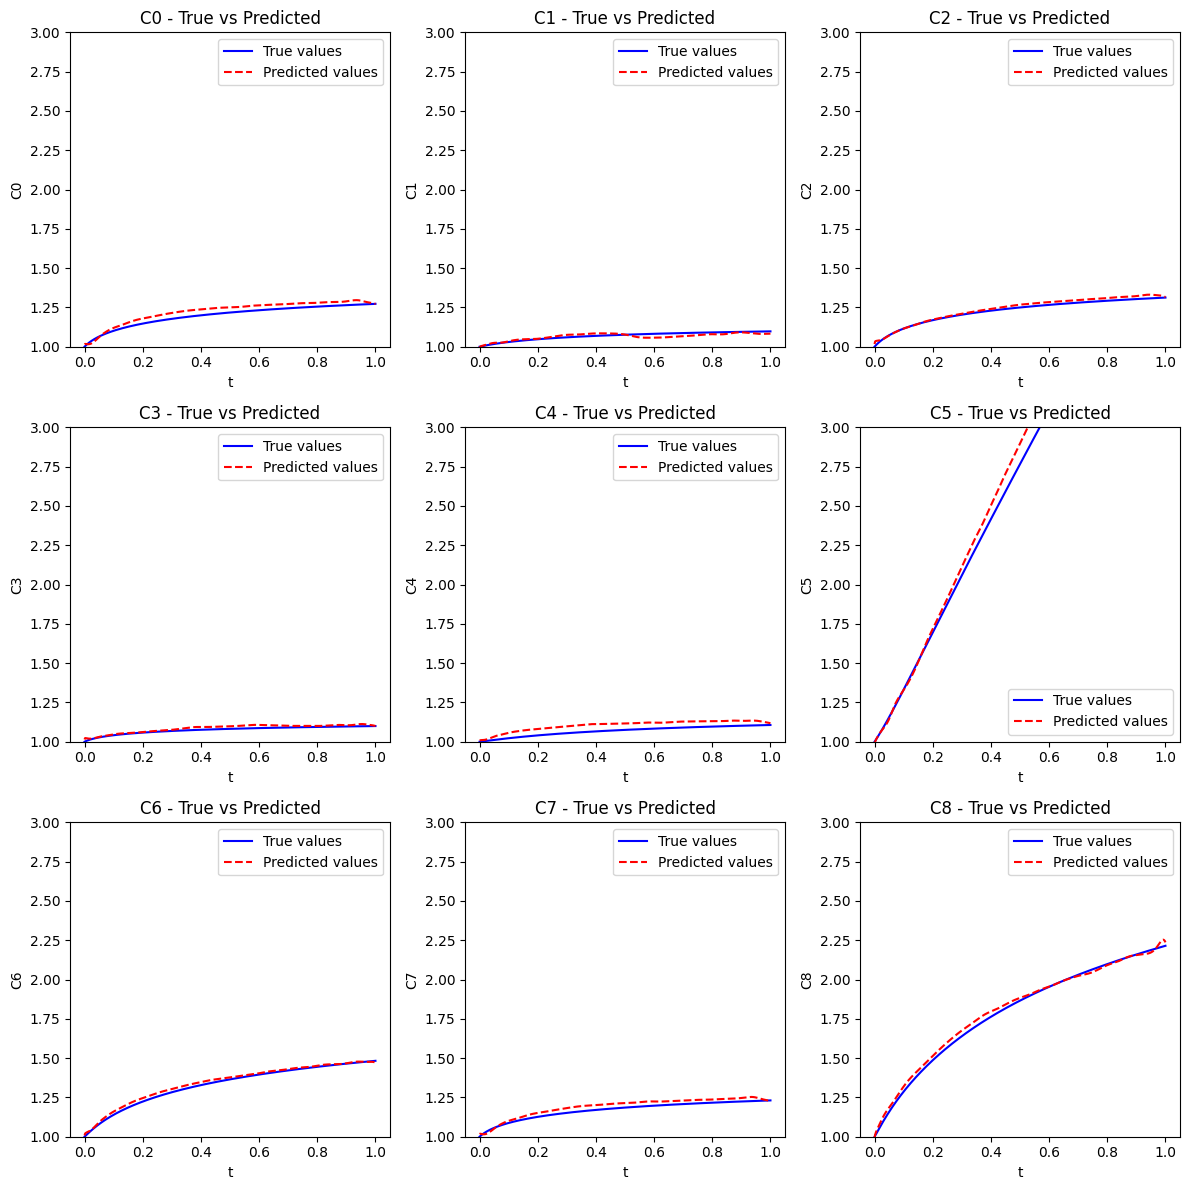

In [41]:
import matplotlib.pyplot as plt


# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

x = np.linspace(0, 1, 601) 

for i in range(9): 
    row, col = divmod(i, 3)  
    ax = axes[row, col]  

    # Plot true vs predicted values for the i-th feature
    ax.plot(x,all_targets[2*i,:].squeeze(), label="True values", color="b")
    ax.plot(x,all_predictions[2*i,:].squeeze(), label="Predicted values", color="r", linestyle="--")
    
    ax.set_xlabel("t")
    ax.set_ylabel(f"C{i}")
    ax.set_title(f"C{i} - True vs Predicted")
    
    ax.set_ylim(1, 3)
    
    ax.legend()
fig.tight_layout()
plt.savefig('FNO_c.pdf')



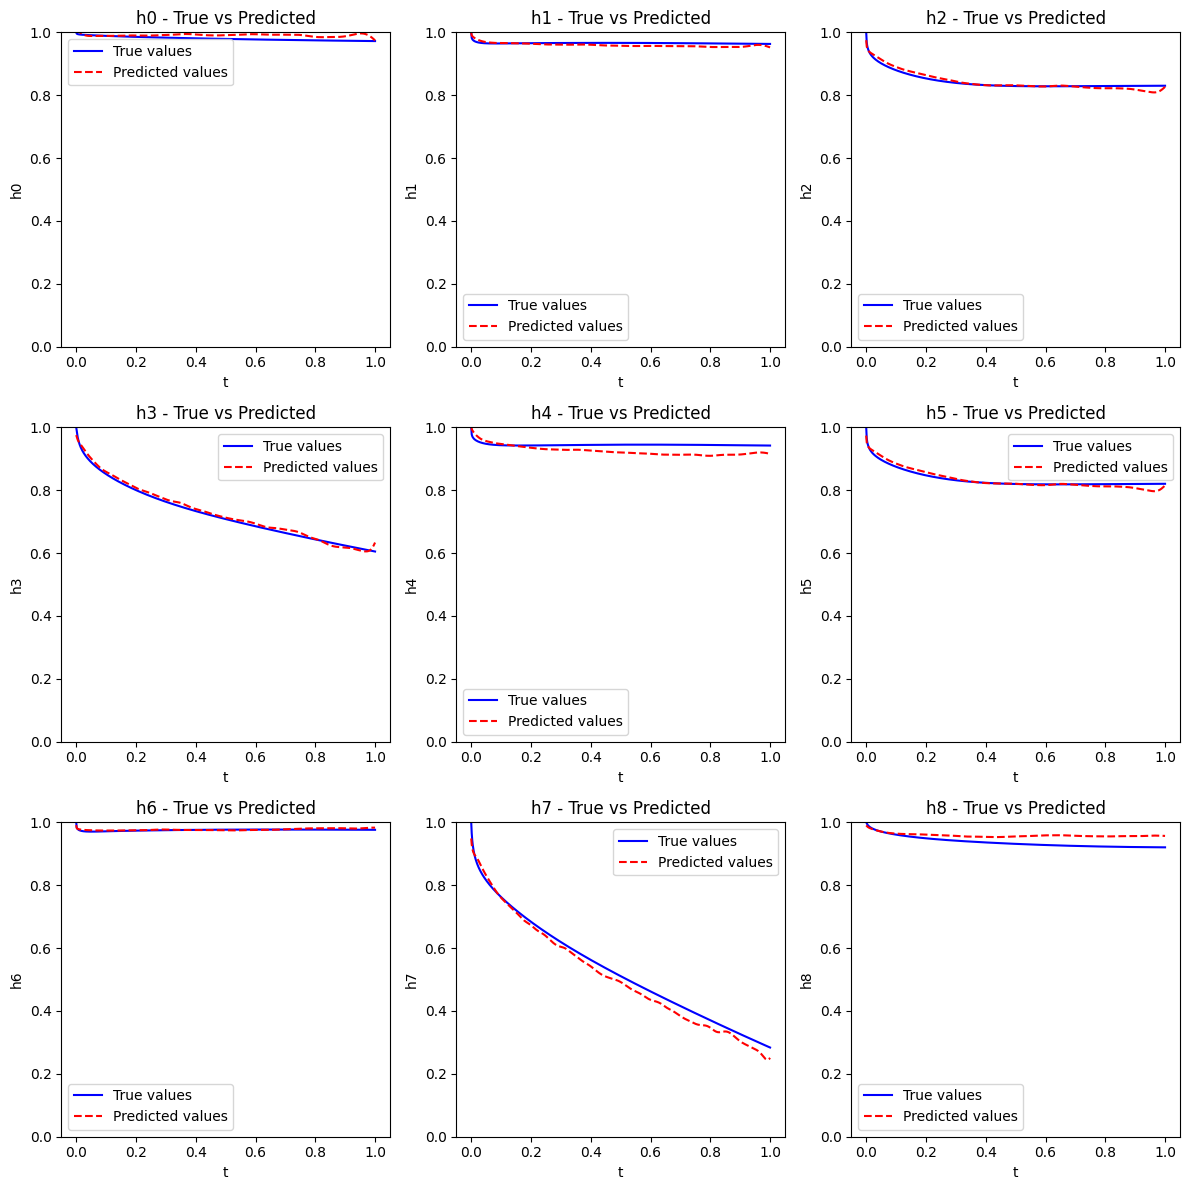

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
x = np.linspace(0, 1, 601) 

for i in range(9): 
    row, col = divmod(i, 3) 
    ax = axes[row, col] 

    # Plot true vs predicted values for the i-th feature
    ax.plot(x,all_targets[i,:].squeeze(), label="True values", color="b")
    ax.plot(x,all_predictions[i,:].squeeze(), label="Predicted values", color="r", linestyle="--")
    
    ax.set_xlabel("t")
    ax.set_ylabel(f"h{i}")
    ax.set_title(f"h{i} - True vs Predicted")

    ax.set_ylim(0, 1)
    ax.legend()

fig.tight_layout()
plt.savefig('FNO_h.pdf')
